In [14]:
import pandas as pd
import spacy
import re
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [15]:
# Step 1: Load spaCy model for Named Entity Recognition (NER)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Please run 'python -m spacy download en_core_web_sm' to install the required spaCy model.")
    exit()

In [16]:
# Step 2: Load the summarization model
try:
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
except Exception:
    print("Ensure 'transformers' library is installed and model accessible.")
    exit()

Device set to use cpu


In [17]:

# Step 3: Load the dataset
file_path = '/content/cyberbullying_tweet.csv'  # Replace with the path to your dataset
dataset = pd.read_csv(file_path)

# Display initial data structure
print("Initial Dataset Structure:")
print(dataset.head())

Initial Dataset Structure:
                                          tweet_text cyberbullying_type
0  @substitute it's.... well, it's not horrible. ...      cyberbullying
1  @Wi1dchild kay loser. today was so boring but ...      cyberbullying
2  @CappyD Man, I thought Chevaldayoff was a huma...      cyberbullying
3  .@tarah @girlziplocked @hypatiadotca @justkell...      cyberbullying
4  @girlziplocked @tarah @hypatiadotca @justkelly...      cyberbullying


In [18]:

# Step 4: Preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

dataset["cleaned_text"] = dataset["tweet_text"].apply(preprocess_text)

In [19]:
# Step 5: Extract victim names using NER
def extract_victims(text):
    doc = nlp(text)
    victims = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]
    return ", ".join(victims) if victims else "Unknown"

dataset["Victim Name"] = dataset["cleaned_text"].apply(extract_victims)

In [20]:
# Step 6: Classify the type of crime
def classify_crime(text):
    crime_keywords = {
        "Hacking": ["hacked", "account compromised", "breach"],
        "Phishing": ["phishing", "scam", "fraudulent"],
        "Identity Theft": ["identity theft", "impersonation", "stolen identity"],
        "Cyberbullying": ["bully", "harassed", "abused"],
        "Malware": ["virus", "malware", "ransomware"]
    }
    for crime, keywords in crime_keywords.items():
        if any(re.search(rf"\b{keyword}\b", text, re.IGNORECASE) for keyword in keywords):
            return crime
    return "Other"

dataset["Type of Crime"] = dataset["cleaned_text"].apply(classify_crime)

In [21]:
# Step 7: Summarize the text
def summarize_text(text):
    if len(text.split()) > 10:  # Summarize only if text has more than 10 words
        try:
            summary = summarizer(text, max_length=50, min_length=10, do_sample=False)
            return summary[0]["summary_text"]
        except Exception:
            return text  # Return original text if summarization fails
    return text

dataset["Summary"] = dataset["cleaned_text"].apply(summarize_text)

Your max_length is set to 50, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 50, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 50, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 50, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max

In [22]:
# Step 8: Save the processed dataset
output_file = "/content/processed_cybercrime_tweets.csv"
dataset.to_csv(output_file, index=False)
print(f"Processed dataset saved to {output_file}.")

Processed dataset saved to /content/processed_cybercrime_tweets.csv.


<ipython-input-24-0bb6aef8d733>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x="Type of Crime", order=dataset["Type of Crime"].value_counts().index, palette="viridis")


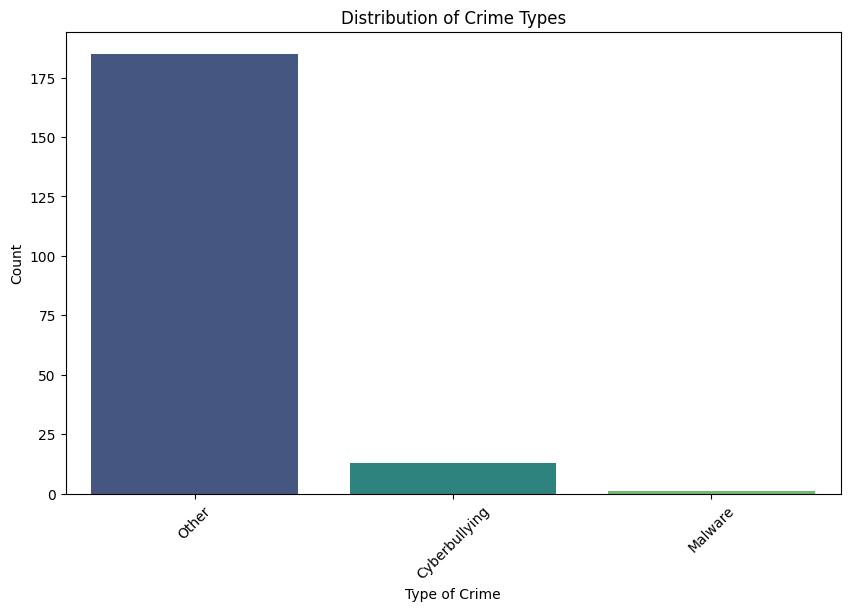

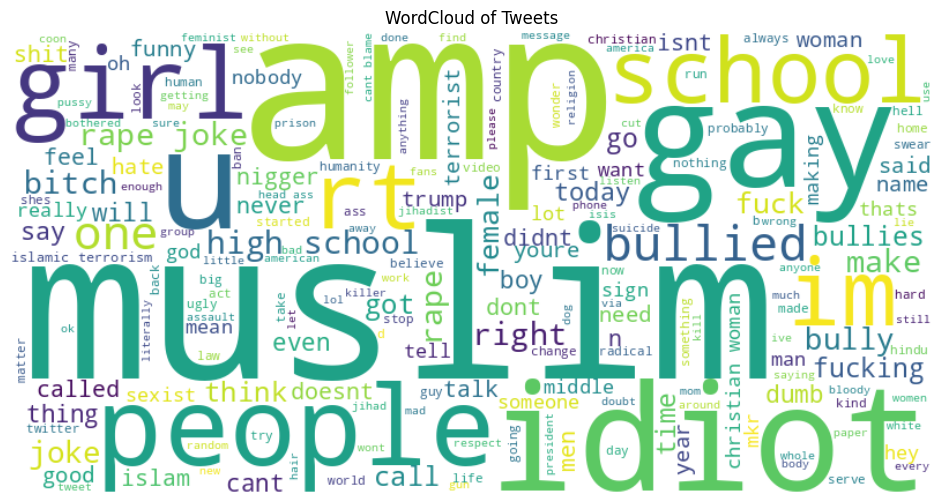

<ipython-input-24-0bb6aef8d733>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=victim_counts.index, x=victim_counts.values, palette="coolwarm")


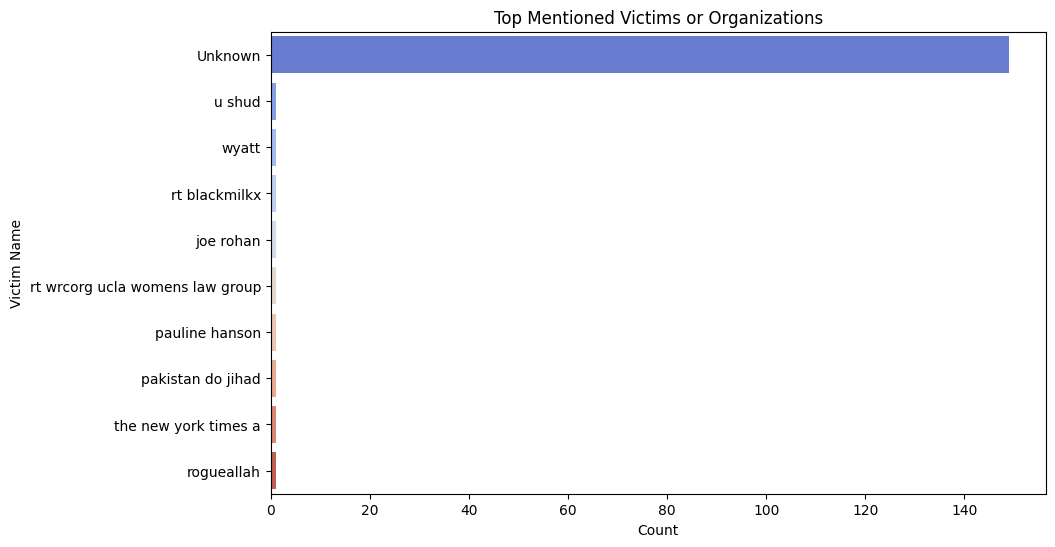

In [24]:
# Step 9: Visualizations
# Plotting the distribution of crime types
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset, x="Type of Crime", order=dataset["Type of Crime"].value_counts().index, palette="viridis")
plt.title("Distribution of Crime Types")
plt.xlabel("Type of Crime")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# WordCloud of tweets
text_data = " ".join(dataset["cleaned_text"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Tweets")
plt.show()

# Victim extraction insights
victim_counts = dataset["Victim Name"].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=victim_counts.index, x=victim_counts.values, palette="coolwarm")
plt.title("Top Mentioned Victims or Organizations")
plt.xlabel("Count")
plt.ylabel("Victim Name")
plt.show()